# Data Exploration

In [51]:
import pandas as pd

# Read and sort data
data = pd.read_csv("C:/Users/IdeaPad/Desktop/ACF/Machine Learning in Finance/FinancialCrises(mod).csv",header=0)
#data.fillna(data.mean(), inplace=True)
data = data.sort_values('year').reset_index(drop=True)

data.isnull().sum()

year               0
country            0
rgdpbarro          0
rgdp               0
loans1           243
bassets2         360
govass          1223
narrowm          155
money            204
gdp              175
iy               202
cpi               70
pop                0
stir             433
ltrate            48
stocks           251
CreditGrowth     298
1yrlag           321
2yrlag           344
crisisST           0
dtype: int64

# Data Standardization

In [14]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler

X = data.iloc[:,2:19]
Y = data["crisisST"]
X_scale = StandardScaler().fit_transform(X)

# Feature Importance Plot

No handles with labels found to put in legend.


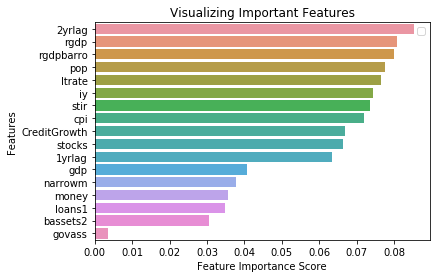

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# # Time series split
tss = TimeSeriesSplit(n_splits=5) 

for train_index, test_index in tss.split(X_scale):
    X_train, X_test = X_scale[train_index], X_scale[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

model1 = RandomForestClassifier(n_estimators=1000)
model1.fit(X_train, Y_train)

feature_imp = pd.Series(model1.feature_importances_,index=X.columns).sort_values(ascending=False)

# #Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# #Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# PCA on Original Data

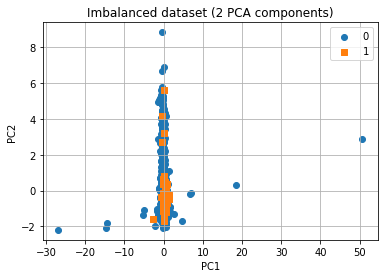

In [26]:
import numpy as np
from sklearn.decomposition import PCA

def plot_2d_space(X, y, label='crisisST'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)  
plot_2d_space(X_train, Y_train, 'Imbalanced dataset (2 PCA components)')

# Model Performance before data resampling

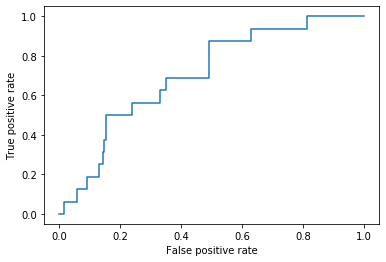

0.7039366883116883


Predicted,0,1
True,,
0,308,0
1,16,0


In [48]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve


xg_class = xgb.XGBClassifier(max_depth=5,objective='binary:logistic')
xg_class.fit(X_train, Y_train)

fpr, tpr, thresholds = roc_curve(Y_test, xg_class.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show() 


pred = xg_class.predict(X_test)
print(roc_auc_score(Y_test,xg_class.predict_proba(X_test)[:,1]))
cm = pd.DataFrame(confusion_matrix(Y_test, pred), index=['0','1'], columns=['0','1'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
cm

# Model Performance after data resampling

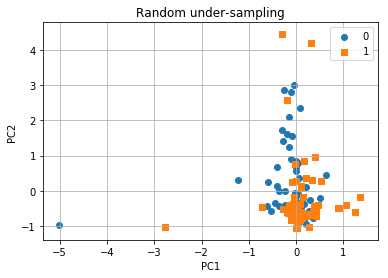

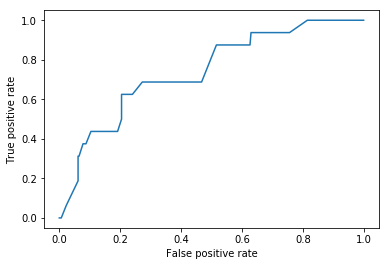

0.7410714285714286


Predicted,0,1
True,,
0,245,63
1,6,10


In [31]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, Y_rus, id_rus = rus.fit_sample(X_train, Y_train)
plot_2d_space(X_rus, Y_rus, 'Random under-sampling')


xg_class.fit(X_rus,Y_rus)

fpr, tpr, thresholds = roc_curve(Y_test, xg_class.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show() 


pred = xg_class.predict(X_test)
print(roc_auc_score(Y_test,xg_class.predict_proba(X_test)[:,1]))
cm = pd.DataFrame(confusion_matrix(Y_test, pred), index=['0','1'], columns=['0','1'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
cm